In [3]:
import numpy as np
import pandas as pd 

### Data preparation

In [6]:
fundamentals_df = pd.read_csv('../input/clear_fundamentals.csv', index_col=0)
fundamentals_df.shape

(428, 12)

In [2]:
sector_embeddings = np.load('../input/sector_embedding.npy')
sector_embeddings.shape

(428, 7)

In [9]:
new_df = pd.concat([
    fundamentals_df, 
    pd.DataFrame(sector_embeddings, index=fundamentals_df.index, columns=['embedding_' + str(i) for i in range(sector_embeddings.shape[-1])])
], axis=1)
new_df.head()

,Symbol,forwardPE,priceToBook,enterpriseToRevenue,profitMargins,trailingEps,forwardEps,beta,52WeekChange,averageVolume,marketCap,payoutRatio,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6
0,MMM,19.240505,18.872610,3.682,0.16011,7.20,7.90,1.104,0.156773,3375564.0,8.095977e+10,0.3972,-14.320090,-21.504538,-1.577519,-11.452251,-9.880412,0.347214,2.985690
1,AOS,17.393120,5.373871,5.275,0.13683,3.59,4.07,1.220,-0.090804,1403941.0,9.919802e+09,0.3733,-14.320090,-21.504538,-1.577519,-11.452251,-9.880412,0.347214,2.985690
2,ABT,25.616278,4.549616,5.486,0.32427,7.97,5.16,0.705,0.168700,6356111.0,2.300540e+11,0.2861,21.712490,0.202544,-21.211306,6.440060,-8.864782,-5.857467,0.027519
4,ACN,18.063255,5.179863,2.305,0.11607,12.58,14.07,1.290,-0.254539,3973364.0,1.582981e+11,0.4558,-12.681352,-8.958301,5.405618,23.820467,5.339387,-4.034334,0.060035
5,ADBE,16.958637,12.998881,6.579,0.30392,15.61,20.55,1.517,-0.386368,3889275.0,1.478337e+11,0.0000,-12.681352,-8.958301,5.405618,23.820467,5.339387,-4.034334,0.060035


In [52]:
new_df.shape

(428, 19)

In [11]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

fundamentals_embeddings = new_df.drop(columns=['Symbol']).values
fundamentals_embeddings = sc.fit_transform(fundamentals_embeddings)

In [21]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch

class FundamentalEmbeddingDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)
    
fundamentals_embeddings_dataset = FundamentalEmbeddingDataset(torch.from_numpy(fundamentals_embeddings))

train_set, test_set = random_split(
    fundamentals_embeddings_dataset, [400, len(fundamentals_embeddings_dataset) - 400]
)

train_loader = DataLoader(train_set, shuffle=True)
test_loader = DataLoader(test_set)

### Latent space exploration using VAE

In [24]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class VAE(nn.Module):
    """   
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim //2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, 2 * latent_dim) # *2 for mean and variance
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def encode(self, x):
        
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
        
        Returns:
            (torch.Tensor, torch.Tensor): Return the distribution parameters learned from
            encoding phase
        """
        x = self.encoder(x)
        
        mu, logvar = torch.chunk(x, 2, dim=-1)
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick
        
        Args:
            mu (torch.Tensor): the mean values of the laten space learned from encoder
            var (torch.Tensor): The log variance values of the laten space distribution leared from encoder
        Returns:
            torch.Tensor: the latent representation of the input
        """
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * logvar)
        # Generate the random noise distributed from normal distribution
        eps = torch.randn_like(logvar)
        return mu + eps * std
    
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x):
        """   
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): input data
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar
    
def vae_loss_function(recon_x, x, mu, log_var):
    """
    Calculate the loss function for VAE operation, sum up both 
    reconstruction loass and KL divergence loss
    
    Args:
        recon_x (torch.Tensor): The reconstructed input data, which aims to be approximate to input data
        x (torch.Tensor): The input data
        mu (torch.Tensor): The mean of latent space distribution
        log_var (torch.Tensor): The log value of variance of latent space distribution
    Return:
        (torch.Tensor): Loss which is summed up both KL loss and reconstruction loss
    """
    recon_loss = F.mse_loss(recon_x, x, reduction='none').sum(-1).mean()
    
    kl_loss = - 0.5 * torch.mean(torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
    
    return recon_loss + kl_loss

Epoch [5/50], Train Loss: 16.8011, Test Loss: 12.7237
Epoch [10/50], Train Loss: 14.9018, Test Loss: 11.7004
Epoch [15/50], Train Loss: 13.3000, Test Loss: 11.0655
Epoch [20/50], Train Loss: 12.9738, Test Loss: 10.5397
Epoch [25/50], Train Loss: 11.7473, Test Loss: 10.0653
Epoch [30/50], Train Loss: 11.1217, Test Loss: 11.2773
Epoch [35/50], Train Loss: 10.9530, Test Loss: 9.0008
Epoch [40/50], Train Loss: 10.9728, Test Loss: 9.1847
Epoch [45/50], Train Loss: 10.2959, Test Loss: 8.8913
Epoch [50/50], Train Loss: 10.3543, Test Loss: 8.4532


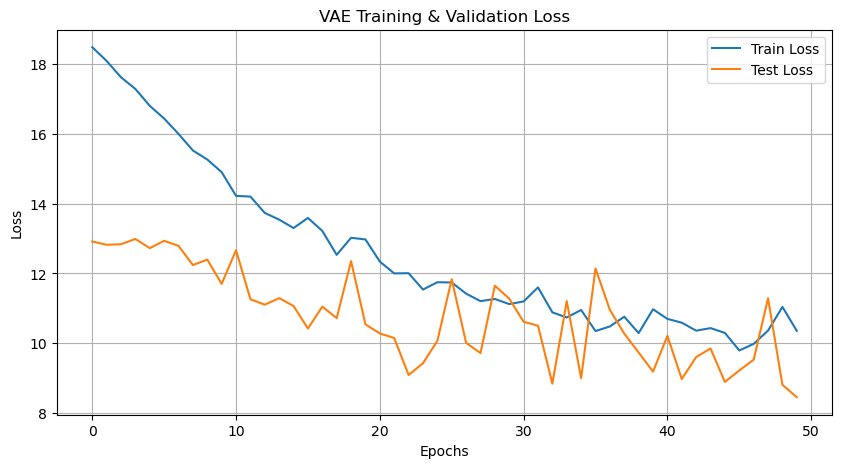

In [31]:
input_dim = fundamentals_embeddings.shape[1]
latent_dim = 16
hidden_dim = 64
epochs = 50
learning_rate = 1e-3


model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = batch.float().to(device)
        
        recon_batch, mu, log_var = model(batch)
        loss = vae_loss_function(recon_batch, batch, mu, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.float().to(device)
            recon_batch, mu, log_var = model(batch)
            loss = vae_loss_function(recon_batch, batch, mu, log_var)
            total_test_loss += loss.item()
            
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
        
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('VAE Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
            

#### Retrain the VAE using fine-tuned architecture

Epoch [5/100], Final Train Loss: 15.9168
Epoch [10/100], Final Train Loss: 14.2638
Epoch [15/100], Final Train Loss: 13.6352
Epoch [20/100], Final Train Loss: 12.7399
Epoch [25/100], Final Train Loss: 12.6474
Epoch [30/100], Final Train Loss: 12.4133
Epoch [35/100], Final Train Loss: 10.5554
Epoch [40/100], Final Train Loss: 10.4809
Epoch [45/100], Final Train Loss: 10.3378
Epoch [50/100], Final Train Loss: 9.9298
Epoch [55/100], Final Train Loss: 9.7251
Epoch [60/100], Final Train Loss: 10.1102
Epoch [65/100], Final Train Loss: 9.2243
Epoch [70/100], Final Train Loss: 9.3752
Epoch [75/100], Final Train Loss: 9.3926
Epoch [80/100], Final Train Loss: 8.8819
Epoch [85/100], Final Train Loss: 9.3112
Epoch [90/100], Final Train Loss: 10.0500
Epoch [95/100], Final Train Loss: 9.1167
Epoch [100/100], Final Train Loss: 8.9081


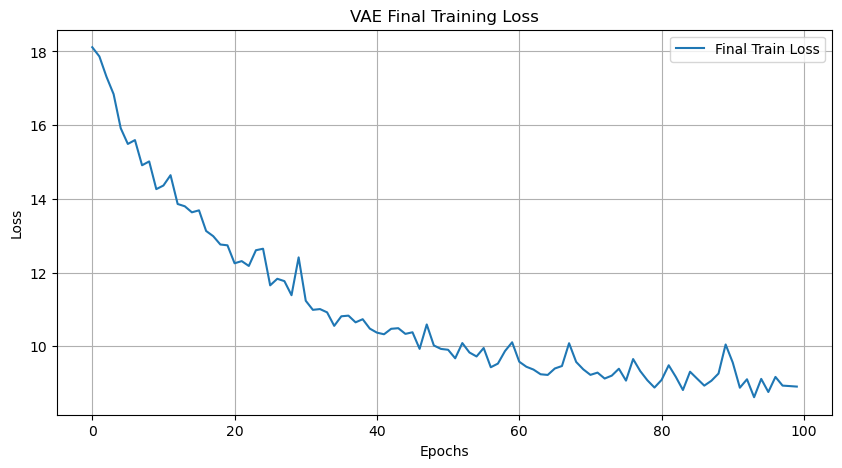

In [50]:
model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

full_dataset = FundamentalEmbeddingDataset(fundamentals_embeddings_dataset)
full_loader = DataLoader(full_dataset)

final_train_losses = []
epochs = 100
for epoch in range(epochs):
    
    model.train()
    total_epoch_loss = 0
    
    for batch in full_loader:
        batch = batch.float().to(device)
        recon, mu, log_var = model(batch)
        loss = vae_loss_function(recon, batch, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_epoch_loss += loss.item()
        
    avg_epoch_loss = total_epoch_loss / len(full_loader)
    final_train_losses.append(avg_epoch_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Final Train Loss: {avg_epoch_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(final_train_losses, label='Final Train Loss')
plt.title('VAE Final Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
    

In [51]:
model.eval()
with torch.no_grad():
    latent_embeddings, _ = model.encode(torch.from_numpy(fundamentals_embeddings).float())
    latent_embeddings = latent_embeddings.numpy()
latent_embeddings.shape

(428, 16)

### Adjacency matrix construction 

In [54]:
from sklearn.metrics import pairwise_distances

In [93]:
distance_matrix = pairwise_distances(latent_embeddings, metric='cosine')
distance_matrix[:5, :5], distance_matrix.shape

(array([[0.        , 0.04978627, 1.1673766 , 1.5464233 , 1.506089  ],
        [0.04978627, 0.        , 1.1779804 , 1.481585  , 1.421752  ],
        [1.1673766 , 1.1779804 , 0.        , 1.4774258 , 1.3395394 ],
        [1.5464233 , 1.481585  , 1.4774258 , 0.        , 0.09524363],
        [1.506089  , 1.421752  , 1.3395394 , 0.09524363, 0.        ]],
       dtype=float32),
 (428, 428))

In [96]:
epsilon = 0.5
gamma_squared = 0.1

adj_matrix = np.exp(- (distance_matrix ** 2 / gamma_squared)) - np.identity(distance_matrix.shape[0])

adj_matrix[adj_matrix < epsilon] = 0

### Graph representation

In [90]:
import networkx as nx

In [70]:
domain_df = pd.read_csv('../input/clear_domain.csv', index_col=0)

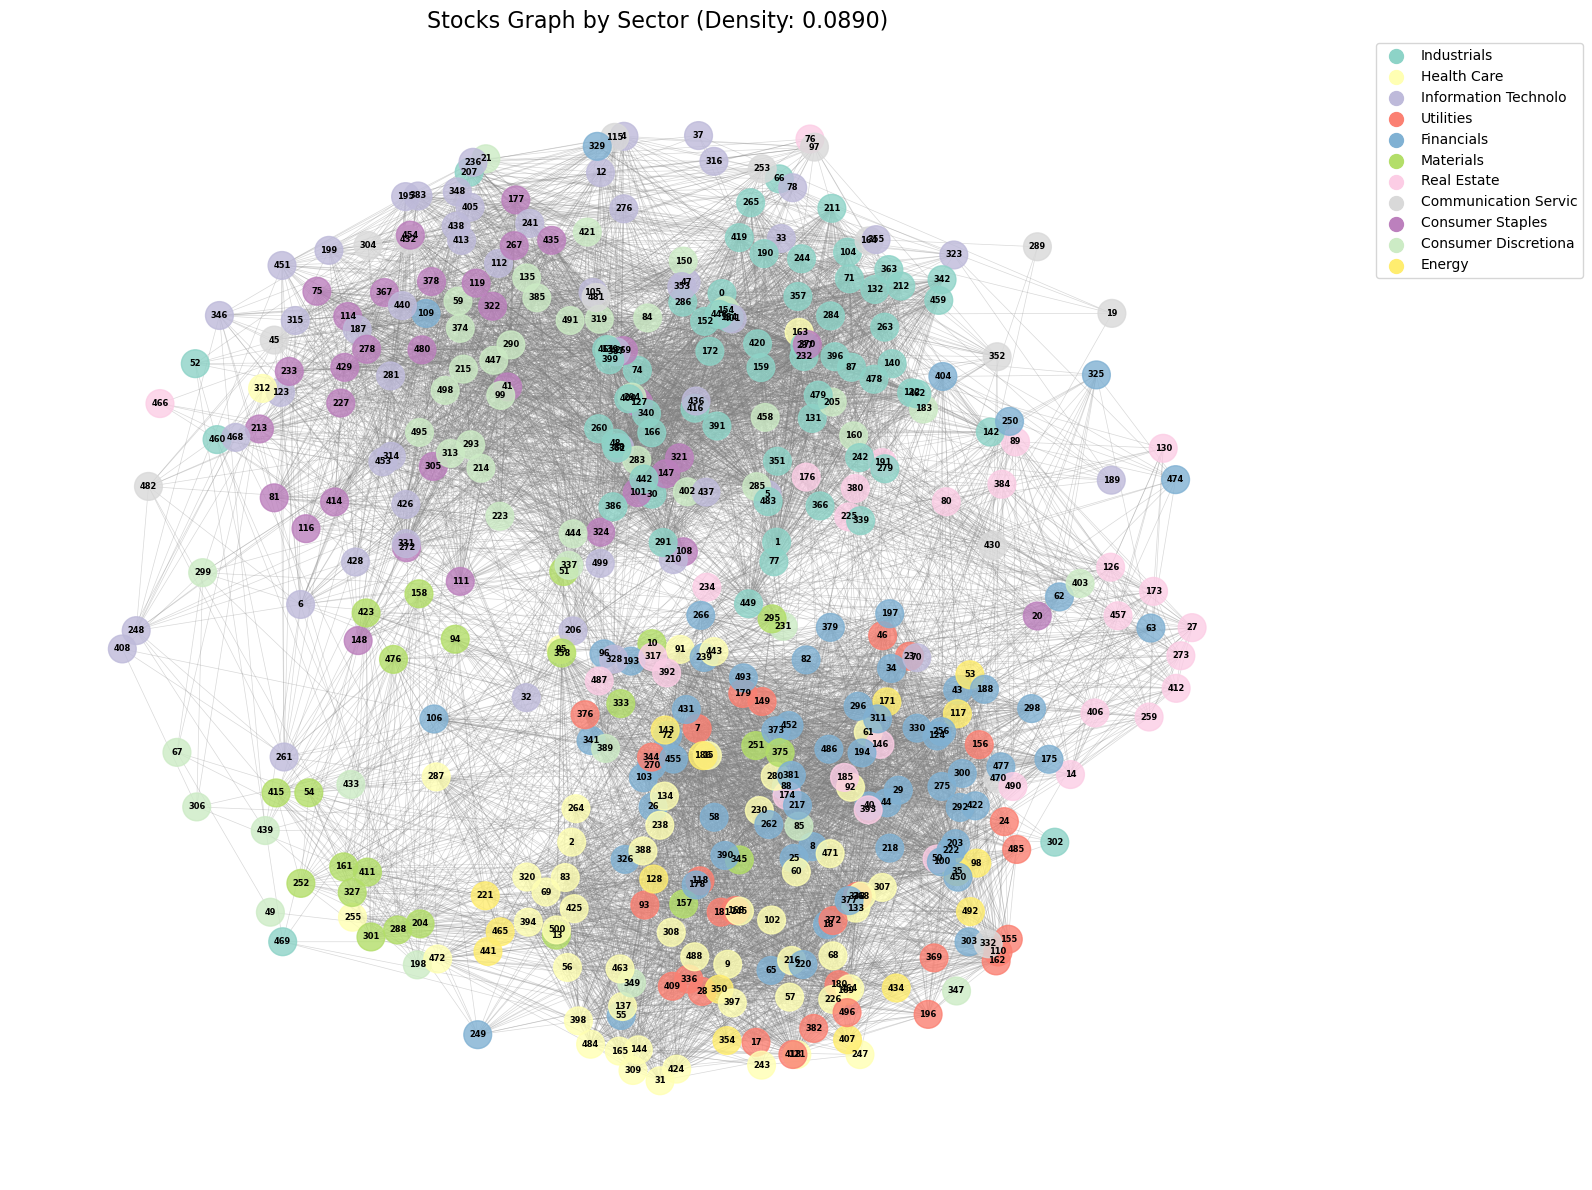

In [97]:
final_graph = nx.from_numpy_array(adj_matrix)
final_graph = nx.relabel_nodes(final_graph, dict(enumerate(fundamentals_df.index)))

# Tạo màu sắc cho từng sector
sectors = domain_df['GICS Sector'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(sectors)))
sector_color_map = dict(zip(sectors, colors))

# Gán màu cho từng node
node_colors = [sector_color_map[domain_df.loc[node, 'GICS Sector']] 
               for node in final_graph.nodes()]

# Tạo layout
pos = nx.spring_layout(final_graph, k=1.5, iterations=100)

# Vẽ đồ thị
plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(final_graph, pos, 
                      node_color=node_colors, 
                      node_size=400, 
                      alpha=0.8)

nx.draw_networkx_edges(final_graph, pos, 
                      edge_color='gray', 
                      alpha=0.3, 
                      width=0.5)

nx.draw_networkx_labels(final_graph, pos, 
                       font_size=6, 
                       font_weight='bold')

# Thêm legend
for sector, color in sector_color_map.items():
    plt.scatter([], [], c=[color], label=sector[:20], s=100)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.title(f'Stocks Graph by Sector (Density: {nx.density(final_graph):.4f})', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

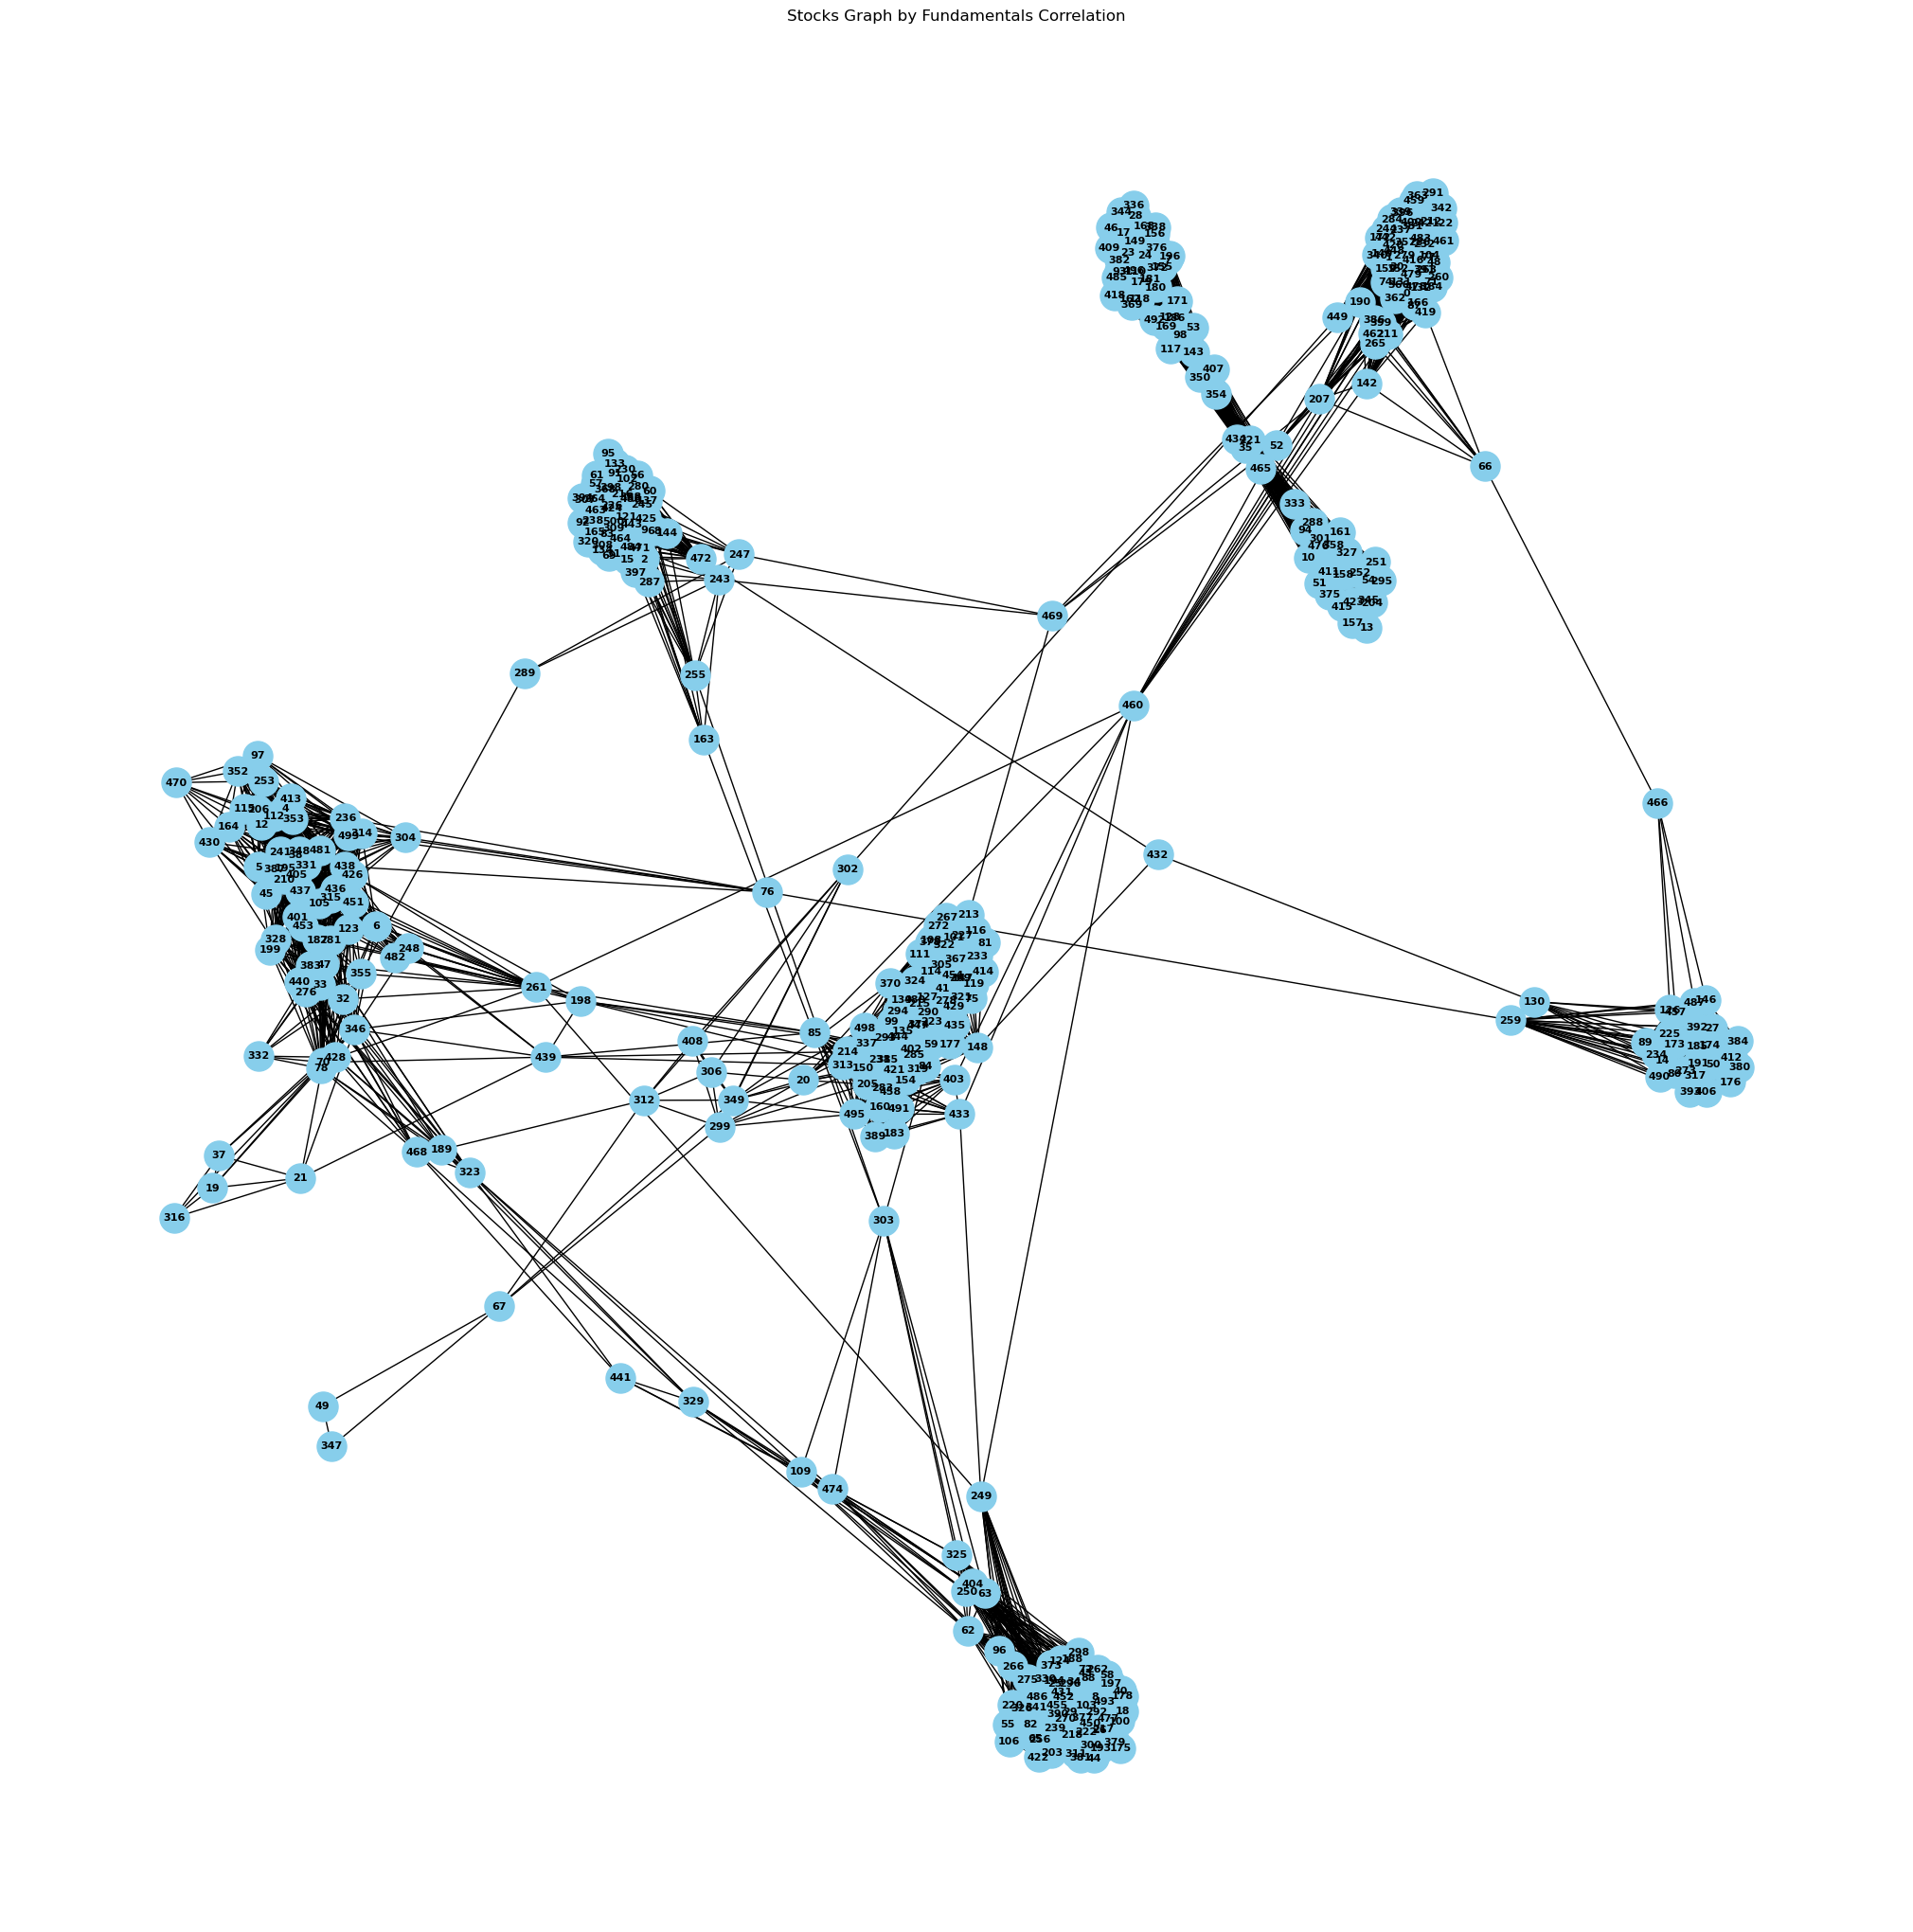

In [98]:
plt.figure(figsize=(20, 20))
nx.draw(final_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(final_graph))
plt.title('Stocks Graph by Fundamentals Correlation')
plt.show()

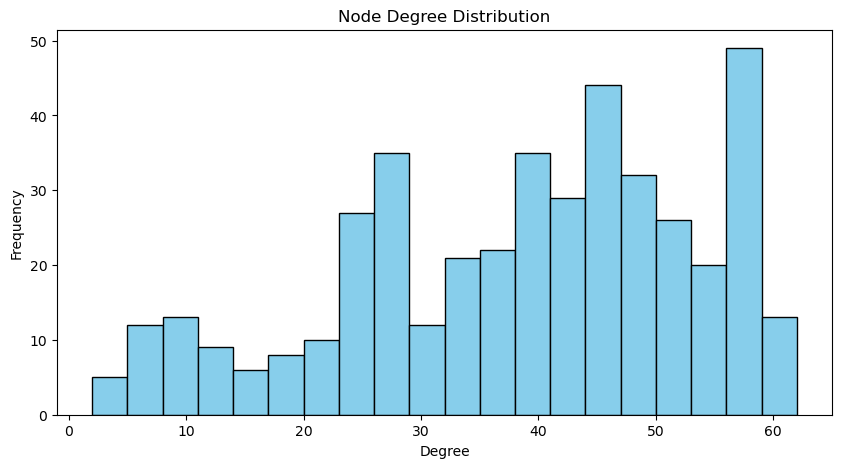

In [99]:
plt.figure(figsize=(10, 5))

connection_num = np.sum((np.abs(adj_matrix) > 0).astype(int), 1)

plt.hist(connection_num, bins=20, color='skyblue', edgecolor='black')
plt.title('Node Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

In [100]:
np.save('../input/adj_vae-bert.npy', adj_matrix)